In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools as it

from votekit.pref_profile import PreferenceProfile
from votekit.ballot import Ballot
from votekit.ballot_generator import DSpatial
from votekit.ballot_generator import Clustered_DSpatial
from votekit.elections import SNTV, STV, Borda, RandomDictator, BoostedRandomDictator, PluralityVeto, fractional_transfer

C:\Users\kq146\AppData\Roaming\Python\Python39\site-packages\networkx\utils\backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


# Metric Ballot Generation

Here we show some examples from a setting where voters and candidates occupy random positions in a metric space. 
With voters metric positions drawn from a distribution $D_V$, candidates metric positions drawn from a distribution $D_C$, 
and a distance function $d: V \times C \rightarrow \mathbb{R}$, we generate ballots by sampling from $D_V$, $D_C$ and 
then create ballots by ranking the candidates by distance to each voter.

In [2]:
# Choose number of voters n
# And the number of candidates m
n = 100
m = 25
candidates = [str(i) for i in range(m)]

In [3]:
# We can use any numpy distribution (or custom distribution -- more on that later)
# to randomly sample  positions for voters and canidates. 
# Here we sample from the following distributions distributions
# Voters: Normal(mean = 1/2, std = 1/10) in 2d
# Candidates: Uniform(0,1) in 2d

# Define a dictionary of parameters for both distributions
# for a full list of possible distributions and their 
# required parameters check out:
# https://numpy.org/doc/1.16/reference/routines.random.html
voter_params = {'loc': 0.5, 'scale': 0.1, 'size': 2}
candidate_params = {'low': 0, 'high': 1, 'size': 2}

# We also define a distance function to compute the 
# distances between any pair of voters and candidates.
# Here, we just use euclidean distance
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

# Now we may pass all of to the DSpatial generation method
generator = DSpatial(candidates = candidates,
                    voter_dist = np.random.normal, voter_params = voter_params,
                    candidate_dist = np.random.uniform, candidate_params = candidate_params,
                    distance = distance)

# Generate a profile from random candidate and voter positions
profile, candidate_position_dict, voter_positions = generator.generate_profile(number_of_ballots = n, seed = None)

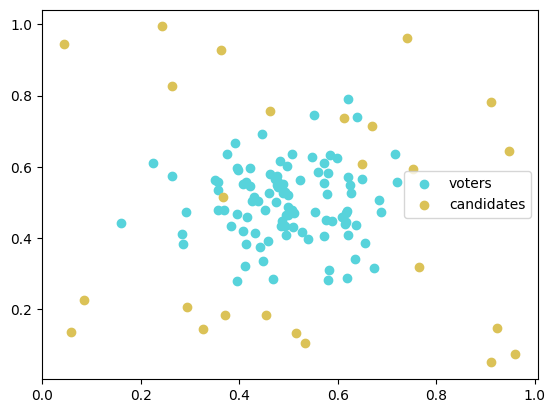

In [4]:
# And then visualize the results
candidate_positions = np.array([i for i in candidate_position_dict.values()])
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = pal[1])
plt.legend()

In [27]:
# In another setting, we may imagine that voters are 
# normally distributed around each of the candidates

# Like before we'll have a candidate distribution. 
# For now, just use the same Uniform(0,1) in 2d
candidate_params = {'low': 0, 'high': 1, 'size': 2}

# And stick to euclidean distance
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

# But now, for each candidate, we'll assign to them a certain 
# number of voters. Let's evenly distribute voters amongst candidates
ballots_per = {c: n//m for c in candidates}

# Those voters will be normally distributed around their candidate
# i.e. the mean of their normal distribution is at the candidate. 
# And we'll give them the remaining parmaters:
voter_params = {'scale': 0.1, 'size': 2}

# Now we may pass all of to the DSpatial generation method
generator = Clustered_DSpatial(candidates = candidates,
                               voter_dist = np.random.normal, voter_params = voter_params,
                               candidate_dist = np.random.uniform, candidate_params = candidate_params,
                               distance = distance)

# And generate a profile from random candidate and voter positions
profile, candidate_position_dict, voter_positions = generator.generate_profile_with_dict(number_of_ballots = ballots_per, seed = None)

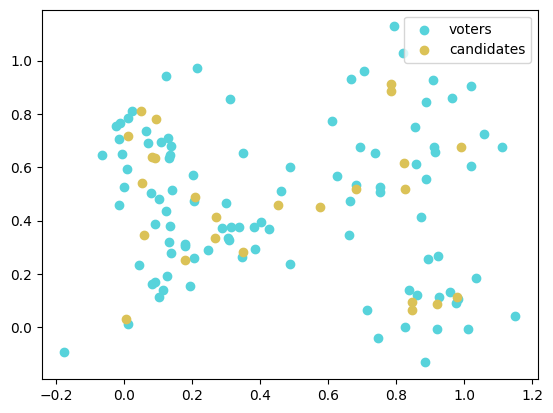

In [28]:
# And then visualize the results
candidate_positions = np.array([i for i in candidate_position_dict.values()])
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = pal[1])
plt.legend()

# Elections in Metric Settings

Suppose voters and candidates occupy positions in a metric space and an election mechanism 
$M$ decides on a winner set by looking at the ranked ballots. In this section we 
compare the location in the metric space of the winning candidates. 
We take inspiration and recreate some examples from [Elkind et al 2019](https://arxiv.org/abs/1901.09217).

In [30]:
# Choose number of voters n
# And the number of candidates m
n = 200
m = 200
candidates = [str(i) for i in range(m)]

# And the number of winners for the election
k = 20 

## Gaussian Generation

Here voters and vandidates are both drawn from the $\sim \text{Normal}(0,1)$ distribution. 

In [31]:
voter_params = {'loc': 0, 'scale': 1, 'size': 2}
candidate_params = {'loc': 0, 'scale': 1, 'size': 2}
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

generator = DSpatial(candidates = candidates,
                    voter_dist = np.random.normal, voter_params = voter_params,
                    candidate_dist = np.random.normal, candidate_params = candidate_params,
                    distance = distance)

In [32]:
# Generate a profile from random candidate and voter positions
profile, candidate_position_dict, voter_positions = generator.generate_profile(number_of_ballots = n, seed = None)

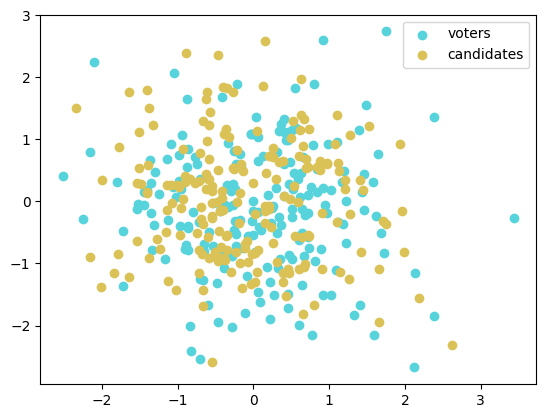

In [33]:
# visualize the results
candidate_positions = np.array([i for i in candidate_position_dict.values()])
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = pal[1])
plt.legend()

### Elections

In [34]:
# Now run a few different election mechanisms on the profile generated above 
# to decide on a winner set. 

# SNTV
sntv_election = SNTV(profile, k)
sntv_results = sntv_election.run_election()
sntv_winners = [int(list(i)[0]) for i in sntv_results.winners()]

# STV
stv_election = STV(profile, fractional_transfer, k, quota = 'droop')
stv_results = stv_election.run_election()
stv_winners = [int(list(i)[0]) for i in stv_results.winners()]

# k-Borda
borda_election = Borda(profile, k)
borda_results = borda_election.run_election()
borda_winners = [int(list(i)[0]) for i in borda_results.winners()]

# k-Random Dictator
random_election = RandomDictator(profile, k)
random_results = random_election.run_election()
random_winners = [int(list(i)[0]) for i in random_results.winners()]

# k-Boosted Random Dictator
boosted_random_election = BoostedRandomDictator(profile, k)
boosted_random_results = boosted_random_election.run_election()
boosted_random_winners = [int(list(i)[0]) for i in boosted_random_results.winners()]

# k-Plurality Veto
plurality_veto_election = PluralityVeto(profile, k)
plurality_veto_results = plurality_veto_election.run_election()
plurality_veto_winners = [int(list(i)[0]) for i in plurality_veto_results.winners()]

Text(0.5, 1.0, 'Plurality Veto')

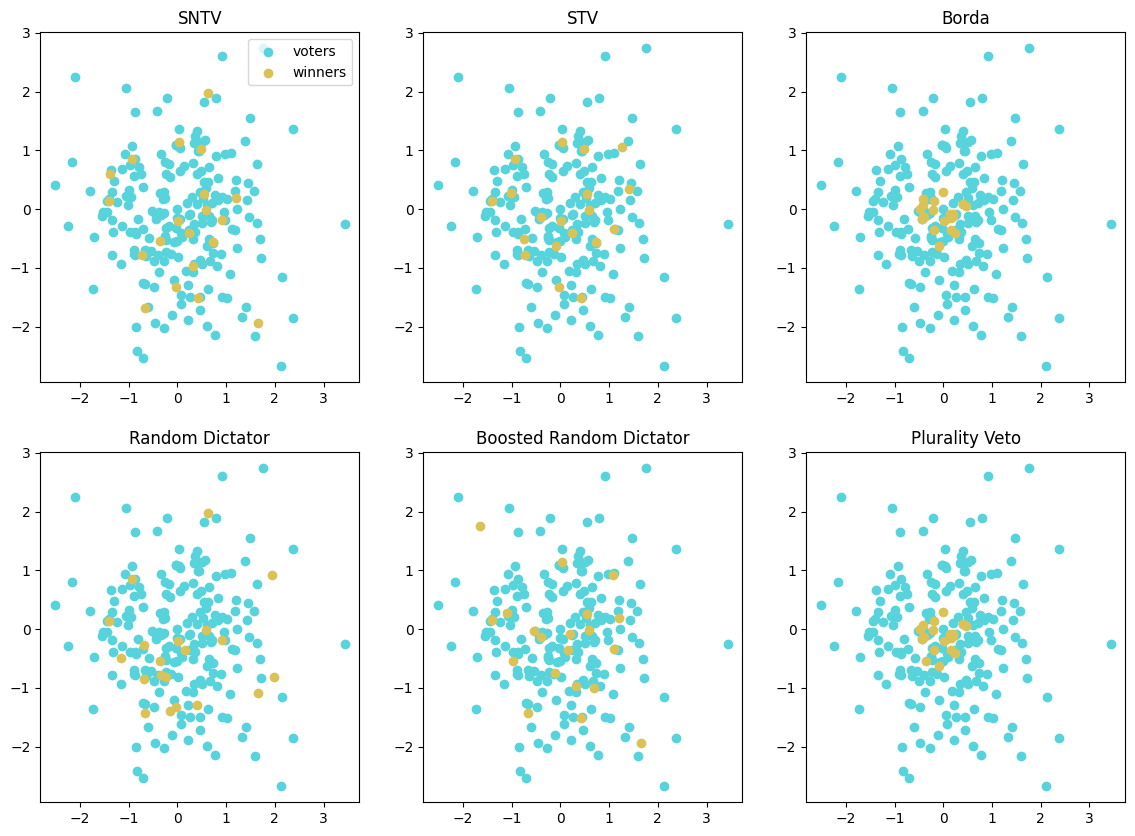

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10)) 

axes[0][0].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[0][0].scatter(candidate_positions[sntv_winners,0], candidate_positions[sntv_winners,1], label = 'winners', color = pal[1])
axes[0][0].set_title('SNTV')
axes[0][0].legend()

axes[0][1].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[0][1].scatter(candidate_positions[stv_winners,0], candidate_positions[stv_winners,1], label = 'winners', color = pal[1])
axes[0][1].set_title('STV')

axes[0][2].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[0][2].scatter(candidate_positions[borda_winners,0], candidate_positions[borda_winners,1], label = 'winners', color = pal[1])
axes[0][2].set_title('Borda')

axes[1][0].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[1][0].scatter(candidate_positions[random_winners,0], candidate_positions[random_winners,1], label = 'winners', color = pal[1])
axes[1][0].set_title('Random Dictator')

axes[1][1].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[1][1].scatter(candidate_positions[boosted_random_winners,0], candidate_positions[boosted_random_winners,1], label = 'winners', color = pal[1])
axes[1][1].set_title('Boosted Random Dictator')

axes[1][2].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[1][2].scatter(candidate_positions[plurality_veto_winners,0], candidate_positions[plurality_veto_winners,1], label = 'winners', color = pal[1])
axes[1][2].set_title('Plurality Veto')

## Uniform Disc Generation

In this example, both voter and candidate positions are sampled  
the uniform disc distribution, which uniformly draws points from a sphere of radius 1 centered at the origin. 

In [36]:
# samples a single point uniformly from a disc with defined radius
def sample_uniform_disc(radius=1):
    # Sample angles uniformly from 0 to 2*pi
    theta = np.random.uniform(0, 2 * np.pi, 1)
    
    # Sample radii with correct distribution
    r = radius * np.sqrt(np.random.uniform(0, 1, 1))
    
    # Convert polar coordinates to Cartesian coordinates
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack((x, y))[0]

In [37]:
voter_params = {'radius': 1}
candidate_params = {'radius': 1}
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

generator = DSpatial(candidates = candidates,
                    voter_dist = sample_uniform_disc, voter_params = voter_params,
                    candidate_dist = sample_uniform_disc, candidate_params = candidate_params,
                    distance = distance)

In [38]:
# Generate a profile from random candidate and voter positions
profile, candidate_position_dict, voter_positions = generator.generate_profile(number_of_ballots = n, seed = None)

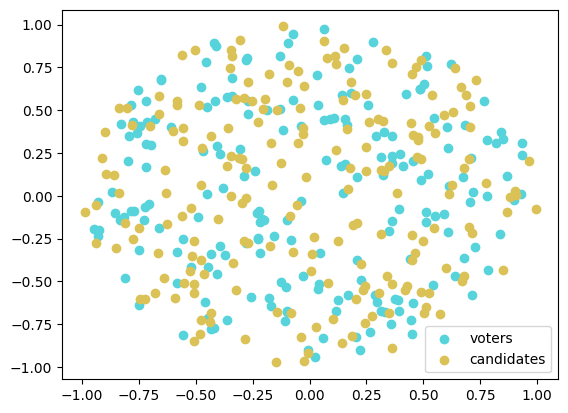

In [39]:
# visualize the results
candidate_positions = np.array([i for i in candidate_position_dict.values()])
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = pal[1])
plt.legend()

### Elections

In [40]:
# SNTV
sntv_election = SNTV(profile, k)
sntv_results = sntv_election.run_election()
sntv_winners = [int(list(i)[0]) for i in sntv_results.winners()]

# STV
stv_election = STV(profile, fractional_transfer, k, quota = 'droop')
stv_results = stv_election.run_election()
stv_winners = [int(list(i)[0]) for i in stv_results.winners()]

# k-Borda
borda_election = Borda(profile, k)
borda_results = borda_election.run_election()
borda_winners = [int(list(i)[0]) for i in borda_results.winners()]

# k-Random Dictator
random_election = RandomDictator(profile, k)
random_results = random_election.run_election()
random_winners = [int(list(i)[0]) for i in random_results.winners()]

# k-Boosted Random Dictator
boosted_random_election = BoostedRandomDictator(profile, k)
boosted_random_results = boosted_random_election.run_election()
boosted_random_winners = [int(list(i)[0]) for i in boosted_random_results.winners()]

# k-Plurality Veto
plurality_veto_election = PluralityVeto(profile, k)
plurality_veto_results = plurality_veto_election.run_election()
plurality_veto_winners = [int(list(i)[0]) for i in plurality_veto_results.winners()]

Text(0.5, 1.0, 'Plurality Veto')

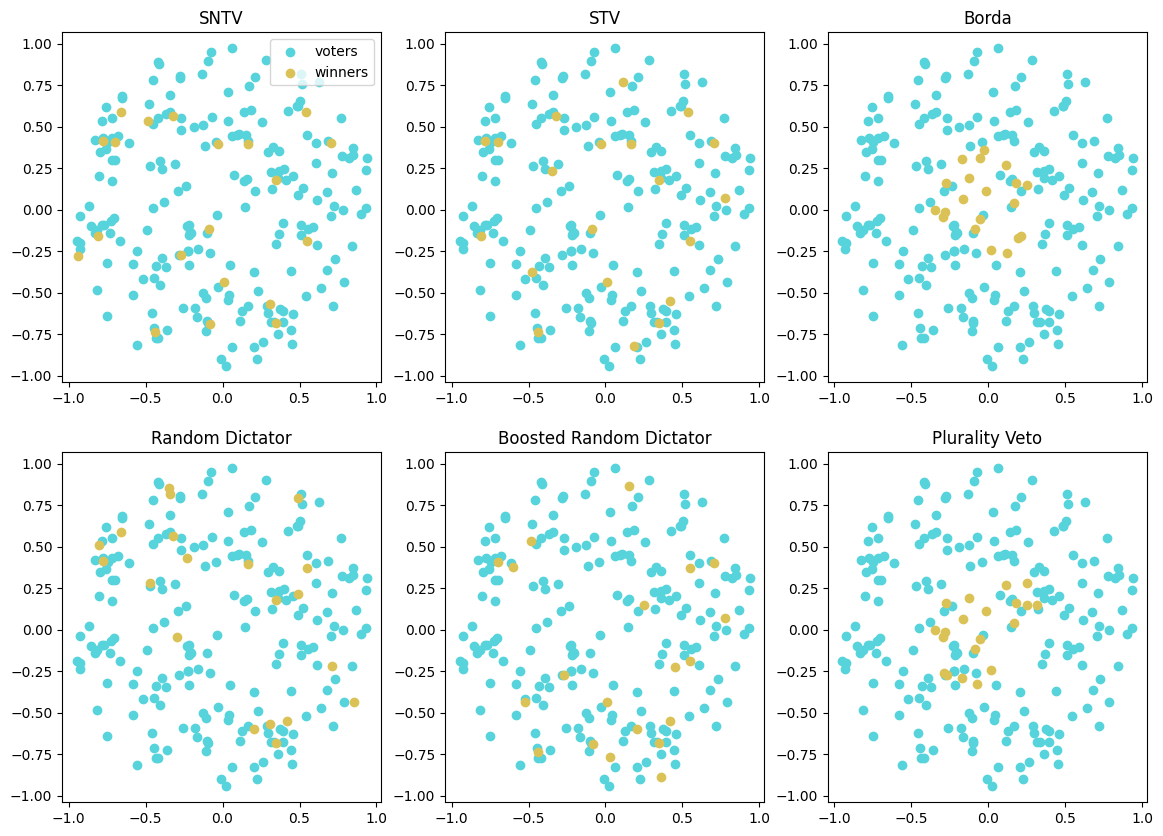

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10)) 

axes[0][0].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[0][0].scatter(candidate_positions[sntv_winners,0], candidate_positions[sntv_winners,1], label = 'winners', color = pal[1])
axes[0][0].set_title('SNTV')
axes[0][0].legend()

axes[0][1].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[0][1].scatter(candidate_positions[stv_winners,0], candidate_positions[stv_winners,1], label = 'winners', color = pal[1])
axes[0][1].set_title('STV')

axes[0][2].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[0][2].scatter(candidate_positions[borda_winners,0], candidate_positions[borda_winners,1], label = 'winners', color = pal[1])
axes[0][2].set_title('Borda')

axes[1][0].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[1][0].scatter(candidate_positions[random_winners,0], candidate_positions[random_winners,1], label = 'winners', color = pal[1])
axes[1][0].set_title('Random Dictator')

axes[1][1].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[1][1].scatter(candidate_positions[boosted_random_winners,0], candidate_positions[boosted_random_winners,1], label = 'winners', color = pal[1])
axes[1][1].set_title('Boosted Random Dictator')

axes[1][2].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[1][2].scatter(candidate_positions[plurality_veto_winners,0], candidate_positions[plurality_veto_winners,1], label = 'winners', color = pal[1])
axes[1][2].set_title('Plurality Veto')

## Uniform Square Generation

Here voters and candidates both follow the $\sim \text{Uniform}(0,1)$ distribution

In [42]:
voter_params = {'low': 0, 'high': 1, 'size': 2}
candidate_params = {'low': 0, 'high': 1, 'size': 2}
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

generator = DSpatial(candidates = candidates,
                    voter_dist = np.random.uniform, voter_params = voter_params,
                    candidate_dist = np.random.uniform, candidate_params = candidate_params,
                    distance = distance)

In [43]:
# Generate a profile from random candidate and voter positions
profile, candidate_position_dict, voter_positions = generator.generate_profile(number_of_ballots = n, seed = None)

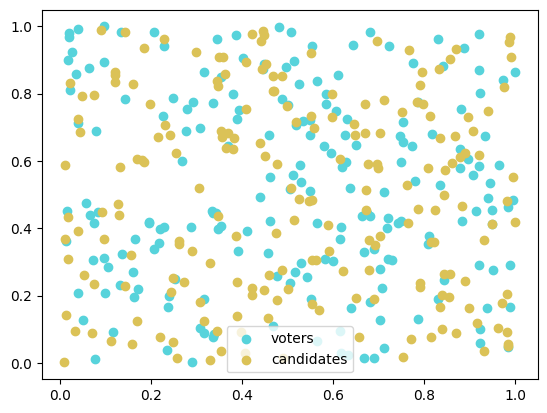

In [44]:
# visualize the results
candidate_positions = np.array([i for i in candidate_position_dict.values()])
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = pal[1])
plt.legend()

### Elections

In [45]:
# SNTV
sntv_election = SNTV(profile, k)
sntv_results = sntv_election.run_election()
sntv_winners = [int(list(i)[0]) for i in sntv_results.winners()]

# STV
stv_election = STV(profile, fractional_transfer, k, quota = 'droop')
stv_results = stv_election.run_election()
stv_winners = [int(list(i)[0]) for i in stv_results.winners()]

# k-Borda
borda_election = Borda(profile, k)
borda_results = borda_election.run_election()
borda_winners = [int(list(i)[0]) for i in borda_results.winners()]

# k-Random Dictator
random_election = RandomDictator(profile, k)
random_results = random_election.run_election()
random_winners = [int(list(i)[0]) for i in random_results.winners()]

# k-Boosted Random Dictator
boosted_random_election = BoostedRandomDictator(profile, k)
boosted_random_results = boosted_random_election.run_election()
boosted_random_winners = [int(list(i)[0]) for i in boosted_random_results.winners()]

# k-Plurality Veto
plurality_veto_election = PluralityVeto(profile, k)
plurality_veto_results = plurality_veto_election.run_election()
plurality_veto_winners = [int(list(i)[0]) for i in plurality_veto_results.winners()]

Text(0.5, 1.0, 'Plurality Veto')

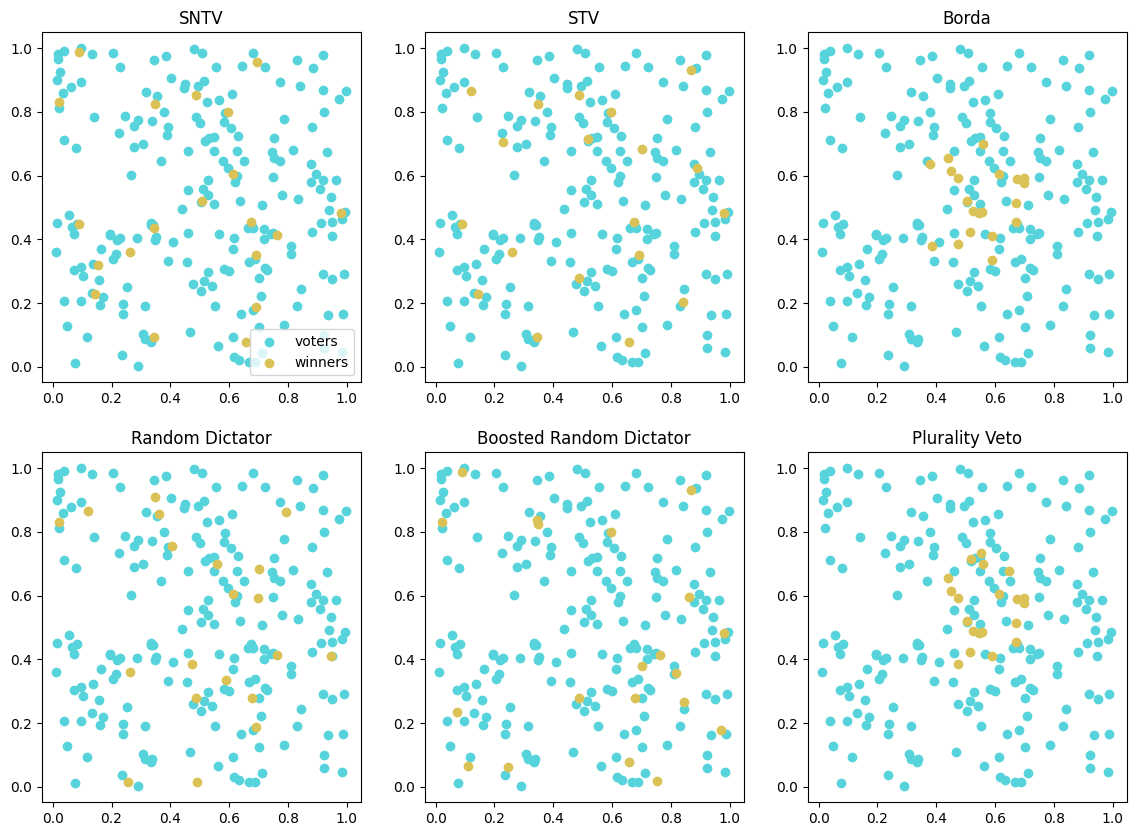

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10)) 

axes[0][0].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[0][0].scatter(candidate_positions[sntv_winners,0], candidate_positions[sntv_winners,1], label = 'winners', color = pal[1])
axes[0][0].set_title('SNTV')
axes[0][0].legend()

axes[0][1].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[0][1].scatter(candidate_positions[stv_winners,0], candidate_positions[stv_winners,1], label = 'winners', color = pal[1])
axes[0][1].set_title('STV')

axes[0][2].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[0][2].scatter(candidate_positions[borda_winners,0], candidate_positions[borda_winners,1], label = 'winners', color = pal[1])
axes[0][2].set_title('Borda')

axes[1][0].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[1][0].scatter(candidate_positions[random_winners,0], candidate_positions[random_winners,1], label = 'winners', color = pal[1])
axes[1][0].set_title('Random Dictator')

axes[1][1].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[1][1].scatter(candidate_positions[boosted_random_winners,0], candidate_positions[boosted_random_winners,1], label = 'winners', color = pal[1])
axes[1][1].set_title('Boosted Random Dictator')

axes[1][2].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[1][2].scatter(candidate_positions[plurality_veto_winners,0], candidate_positions[plurality_veto_winners,1], label = 'winners', color = pal[1])
axes[1][2].set_title('Plurality Veto')

## 4-Gaussian Generation

Finally in this example voters are sampled from a multimodal gaussian distribution with 4 centers -- representing 4 different parties. Candidates are sampled from the $\sim \text{uniform}(-3,3)$ distribution.

In [47]:
# samples a single point from mixture of gaussians
def sample_from_mixture(means, stds, weights):
    # Ensure the weights sum to 1
    weights = np.array(weights)
    weights /= weights.sum()
    
    # Choose one of the distributions based on the weights
    distribution_index = np.random.choice(len(means), p=weights)
    
    # Sample a point from the chosen distribution
    mean = means[distribution_index]
    std = stds[distribution_index]
    point = np.random.normal(loc=mean, scale=std, size=(2,))
    
    return point

In [48]:
# Means for each of the 4 Gaussian distributions
means = [(-2, -2), (2, -2), (-2, 2), (2, 2)]
stds = [0.5, 0.5, 0.5, 0.5]  # Standard deviations for each Gaussian
weights = [0.25, 0.25, 0.25, 0.25]  # Weights for each Gaussian

voter_params = {'means': means, 'stds': stds, 'weights': weights}
#candidate_params = {'means': means, 'stds': stds, 'weights': weights}
candidate_params = {'low': -3, 'high': 3, 'size': 2}

distance = lambda point1, point2: np.linalg.norm(point1 - point2)

generator = DSpatial(candidates = candidates,
                    voter_dist = sample_from_mixture, voter_params = voter_params,
                    candidate_dist = np.random.uniform, candidate_params = candidate_params,
                    distance = distance)

In [49]:
# Generate a profile from random candidate and voter positions
profile, candidate_position_dict, voter_positions = generator.generate_profile(number_of_ballots = n, seed = None)

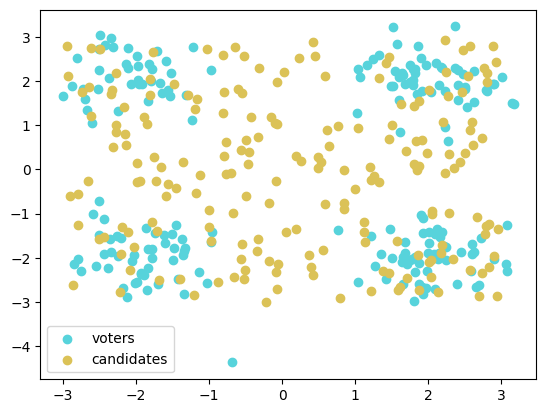

In [50]:
# visualize the results
candidate_positions = np.array([i for i in candidate_position_dict.values()])
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = pal[1])
plt.legend()

### Elections

In [51]:
# SNTV
sntv_election = SNTV(profile, k)
sntv_results = sntv_election.run_election()
sntv_winners = [int(list(i)[0]) for i in sntv_results.winners()]

# STV
stv_election = STV(profile, fractional_transfer, k, quota = 'droop')
stv_results = stv_election.run_election()
stv_winners = [int(list(i)[0]) for i in stv_results.winners()]

# k-Borda
borda_election = Borda(profile, k)
borda_results = borda_election.run_election()
borda_winners = [int(list(i)[0]) for i in borda_results.winners()]

# k-Random Dictator
random_election = RandomDictator(profile, k)
random_results = random_election.run_election()
random_winners = [int(list(i)[0]) for i in random_results.winners()]

# k-Boosted Random Dictator
boosted_random_election = BoostedRandomDictator(profile, k)
boosted_random_results = boosted_random_election.run_election()
boosted_random_winners = [int(list(i)[0]) for i in boosted_random_results.winners()]

# k-Plurality Veto
plurality_veto_election = PluralityVeto(profile, k)
plurality_veto_results = plurality_veto_election.run_election()
plurality_veto_winners = [int(list(i)[0]) for i in plurality_veto_results.winners()]

Text(0.5, 1.0, 'Plurality Veto')

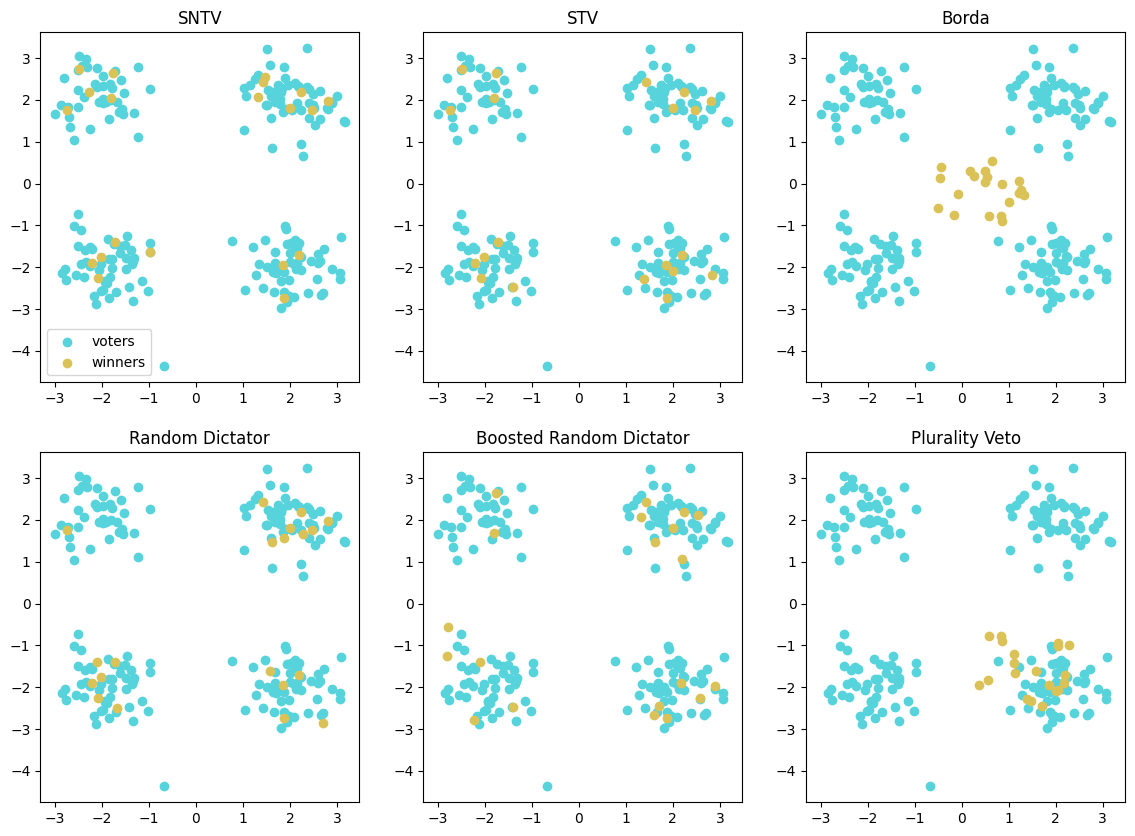

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10)) 

axes[0][0].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[0][0].scatter(candidate_positions[sntv_winners,0], candidate_positions[sntv_winners,1], label = 'winners', color = pal[1])
axes[0][0].set_title('SNTV')
axes[0][0].legend()

axes[0][1].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[0][1].scatter(candidate_positions[stv_winners,0], candidate_positions[stv_winners,1], label = 'winners', color = pal[1])
axes[0][1].set_title('STV')

axes[0][2].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[0][2].scatter(candidate_positions[borda_winners,0], candidate_positions[borda_winners,1], label = 'winners', color = pal[1])
axes[0][2].set_title('Borda')

axes[1][0].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[1][0].scatter(candidate_positions[random_winners,0], candidate_positions[random_winners,1], label = 'winners', color = pal[1])
axes[1][0].set_title('Random Dictator')

axes[1][1].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[1][1].scatter(candidate_positions[boosted_random_winners,0], candidate_positions[boosted_random_winners,1], label = 'winners', color = pal[1])
axes[1][1].set_title('Boosted Random Dictator')

axes[1][2].scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
axes[1][2].scatter(candidate_positions[plurality_veto_winners,0], candidate_positions[plurality_veto_winners,1], label = 'winners', color = pal[1])
axes[1][2].set_title('Plurality Veto')